## Import

In [9]:
import os
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.dataset import ValidSplit
import pandas as pd
from braindecode.models import EEGNetv4

In [10]:
def plot_confusion_matrices(cm, label_mapping, experiment_name):
    """Plotta le confusion matrix"""
    labels = [k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])]
    
    # Normalizza la confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion matrix non normalizzata
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title(f"Confusion Matrix - {experiment_name}")
    ax1.set_xlabel("Predicted Label")
    ax1.set_ylabel("True Label")
    
    # Confusion matrix normalizzata
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_title(f"Normalized Confusion Matrix - {experiment_name}")
    ax2.set_xlabel("Predicted Label")
    ax2.set_ylabel("True Label")
    
    plt.tight_layout()
    plt.show()

## Funzioni

In [3]:
def calculate_final_metrics(all_segment_true, all_segment_pred, all_subject_true, all_subject_pred, 
                          subject_results, segment_accuracies, label_mapping, experiment_name):
    """Calcola e stampa tutte le metriche finali"""
    
    print(f"\n" + "="*50)
    print(f"📈 RISULTATI FINALI - {experiment_name}")
    print("="*50)
    
    # Metriche sui segmenti
    seg_acc = accuracy_score(all_segment_true, all_segment_pred)
    seg_prec = precision_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    seg_rec = recall_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    seg_f1 = f1_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    
    print("\nMETRICHE SUI SEGMENTI:")
    print(f"Accuracy: {seg_acc:.3f} ± {np.std(segment_accuracies):.3f}")
    print(f"Precision: {seg_prec:.3f}")
    print(f"Recall: {seg_rec:.3f}")
    print(f"F1-Score: {seg_f1:.3f}")
    
    # Metriche sui soggetti (moda)
    subj_acc = accuracy_score(all_subject_true, all_subject_pred)
    subj_prec = precision_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    subj_rec = recall_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    subj_f1 = f1_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    
    subject_acc_values = [r['correct'] for r in subject_results]
    
    print("\nMETRICHE SUI SOGGETTI (Moda):")
    print(f"Accuracy: {subj_acc:.3f} ± {np.std(subject_acc_values):.3f}")
    print(f"Precision: {subj_prec:.3f}")
    print(f"Recall: {subj_rec:.3f}")
    print(f"F1-Score: {subj_f1:.3f}")
    
    # Stampa risultati per soggetto
    print("\nRISULTATI PER SOGGETTO:")
    for result in subject_results:
        status = "Y" if result['correct'] else "N"
        print(f"{status} {result['subject']}: {result['true_label']} → {result['pred_label']} "
              f"(seg_acc: {result['segment_accuracy']:.3f}, n_seg: {result['n_segments']})")
    
    # Classification report
    print("\n🔸 CLASSIFICATION REPORT (Soggetti):")
    
    # Ottieni le classi uniche effettivamente presenti nei dati
    unique_classes = sorted(set(all_subject_true + all_subject_pred))
    
    # Crea target_names basati sulle classi uniche
    if len(unique_classes) == len(set(label_mapping.values())):
        # Caso normale: ogni valore numerico corrisponde a una sola etichetta
        inverse_mapping = {v: k for k, v in label_mapping.items()}
        target_names = [inverse_mapping[cls] for cls in unique_classes]
    else:
        # Caso speciale: alcune classi sono mappate allo stesso valore (es. A e F -> 1)
        # Trova tutte le etichette che mappano a ciascuna classe numerica
        class_to_labels = {}
        for label, numeric in label_mapping.items():
            if numeric not in class_to_labels:
                class_to_labels[numeric] = []
            class_to_labels[numeric].append(label)
        
        target_names = []
        for cls in unique_classes:
            if len(class_to_labels[cls]) == 1:
                target_names.append(class_to_labels[cls][0])
            else:
                # Se più etichette mappano alla stessa classe, uniscile
                target_names.append('+'.join(sorted(class_to_labels[cls])))
    
    print(classification_report(all_subject_true, all_subject_pred, target_names=target_names))
    
    # Confusion Matrix
    cm_subjects = confusion_matrix(all_subject_true, all_subject_pred)
    plot_confusion_matrices(cm_subjects, label_mapping, experiment_name)
    
    # Prepara risultati per return
    results = {
        'experiment_name': experiment_name,
        'n_subjects': len(subject_results),
        'n_segments_total': len(all_segment_true),
        
        # Metriche segmenti
        'segments': {
            'accuracy': seg_acc,
            'accuracy_std': np.std(segment_accuracies),
            'precision': seg_prec,
            'recall': seg_rec,
            'f1_score': seg_f1
        },
        
        # Metriche soggetti
        'subjects': {
            'accuracy': subj_acc,
            'accuracy_std': np.std(subject_acc_values),
            'precision': subj_prec,
            'recall': subj_rec,
            'f1_score': subj_f1
        },
        
        'subject_results': subject_results,
        'confusion_matrix': cm_subjects.tolist()
    }
    
    return results


In [4]:
def evaluate_loso_models(experiment_name, memmap_dir, all_subjects, true_labels, subject_to_recordings, label_mapping, net):
    """
    Carica i modelli LOSO salvati e calcola le metriche di valutazione complete.
    
    Args:
        experiment_name (str): Nome dell'esperimento
        memmap_dir (str): Directory dove sono salvati i modelli
        all_subjects (list): Lista di tutti i soggetti
        true_labels (dict): Etichette vere per ogni soggetto
        subject_to_recordings (dict): Registrazioni per ogni soggetto
        label_mapping (dict): Mappatura etichette stringa -> intero
    
    Returns:
        dict: Risultati completi dell'esperimento LOSO
    """
    
    save_dir = os.path.join(memmap_dir, experiment_name)
    inverse_mapping = {v: k for k, v in label_mapping.items()}
    
    # Liste per raccogliere tutte le predizioni
    all_segment_true = []
    all_segment_pred = []
    all_subject_true = []
    all_subject_pred = []
    
    # Liste per accuracies individuali
    segment_accuracies = []
    subject_results = []
    
    print(f"\nEvaluating LOSO experiment: {experiment_name}")
    print(f"Found models directory: {save_dir}")
    
    for left_out_subject in all_subjects:
        model_path = os.path.join(save_dir, f"model_test_LOSO_noSubject_{left_out_subject}.pt")
        
        if not os.path.exists(model_path):
            print(f"⚠️  Modello non trovato per {left_out_subject}: {model_path}")
            continue
            
        print(f"\nEvaluating subject: {left_out_subject}")
        
    
        
        # Carica i parametri del modello salvato
        net.load_params(model_path)
        
        # Prepara i dati di test per il soggetto lasciato fuori
        X_test = np.stack(subject_to_recordings[left_out_subject])
        true_label_subject = true_labels[left_out_subject]
        true_label_numeric = label_mapping[true_label_subject]
        
        # Crea le etichette per tutti i segmenti del soggetto
        y_test_segments = [true_label_numeric] * len(subject_to_recordings[left_out_subject])
        
        # Predici sui segmenti
        y_pred_segments = net.predict(X_test)
        
        # Calcola accuracy sui segmenti
        segment_acc = accuracy_score(y_test_segments, y_pred_segments)
        segment_accuracies.append(segment_acc)
        
        # Aggiungi alle liste globali per metriche complessive sui segmenti
        all_segment_true.extend(y_test_segments)
        all_segment_pred.extend(y_pred_segments)
        
        # Calcola predizione del soggetto tramite moda
        subject_pred_numeric = mode(y_pred_segments, keepdims=True).mode[0]
        subject_pred_label = inverse_mapping[subject_pred_numeric]
        
        # Risultato per questo soggetto
        subject_correct = (subject_pred_numeric == true_label_numeric)
        subject_results.append({
            'subject': left_out_subject,
            'true_label': true_label_subject,
            'pred_label': subject_pred_label,
            'correct': subject_correct,
            'segment_accuracy': segment_acc,
            'n_segments': len(y_pred_segments)
        })
        
        # Aggiungi alle liste globali per metriche sui soggetti
        all_subject_true.append(true_label_numeric)
        all_subject_pred.append(subject_pred_numeric)
        
        print(f"   True: {true_label_subject}, Pred: {subject_pred_label}, "
              f"Correct: {subject_correct}, Seg_Acc: {segment_acc:.3f}")
    
    # Calcola metriche finali
    results = calculate_final_metrics(
        all_segment_true, all_segment_pred,
        all_subject_true, all_subject_pred,
        subject_results, segment_accuracies,
        label_mapping, experiment_name
    )
    
    return results

## Subject_to_Recording and DataFrame

In [5]:
df = pd.read_csv("Data/participants.tsv", sep="\t")

In [6]:
import mne
import os
import numpy as np
import re
import pandas as pd

#TODO: Warning: NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


base_path = "Data"
desired_channels = ['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8',
                    'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'P3', 'P4',
                    'Pz', 'T3', 'T4', 'T5', 'T6']
desired_n_times = 1000  # Numero di campioni per segmento
desired_sfreq = 500     # Frequenza di campionamento desiderata (Hz)

patient_epochs = []
patient_labels = []  # Lista per salvare le label per ogni segmento (epoch)

def extract_subject_number(subdir_name):
    match = re.search(r'\d+', subdir_name)
    return int(match.group()) if match else float('inf')

# Ottieni e ordina le sottodirectory dei soggetti
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
subdirs_sorted = sorted(subdirs, key=extract_subject_number)


subject_to_recordings = {} # per salvare le registrazioni per ogni soggetto

for subdir in subdirs_sorted:
    subdir_path = os.path.join(base_path, subdir)
    eeg_path = os.path.join(subdir_path, 'eeg')
    if os.path.isdir(eeg_path):
        # Trova il file .set (EEGLAB)
        set_file = next((f for f in os.listdir(eeg_path) if f.endswith('.set')), None)
        if set_file:
            set_path = os.path.join(eeg_path, set_file)
            raw = mne.io.read_raw_eeglab(set_path, preload=True)
            
            # Seleziona solo i canali desiderati
            raw.pick_channels(desired_channels)
            
            # Risample se necessario
            if raw.info['sfreq'] != desired_sfreq:
                raw.resample(desired_sfreq)
            
            # Ottieni il numero di campioni della registrazione (puoi anche usare il JSON, se presente)
            n_samples = raw.n_times  
              
            
          
            # Suddividi l'intera registrazione in segmenti di 'desired_n_times' campioni
            segments = []
            for start in range(0, n_samples, desired_n_times):
                end = start + desired_n_times
                if end <= n_samples:
                    seg_data = raw[:, start:end][0]
                else:
                    # Se l'ultimo segmento è più corto, aggiungi padding con zeri
                    seg_data = raw[:, start:n_samples][0]
                    padding = np.zeros((len(desired_channels), desired_n_times - seg_data.shape[1]))
                    seg_data = np.hstack((seg_data, padding))
                segments.append(seg_data)
                 
            
            # Crea un array 3D: (numero_di_segmenti, numero_di_canali, desired_n_times)
            epochs_data = np.array(segments)
            n_epochs = epochs_data.shape[0]
            
            # Crea l'oggetto info e l'array degli eventi con tempi univoci
            info = mne.create_info(ch_names=desired_channels, sfreq=desired_sfreq, ch_types='eeg')
            events = np.array([[i * desired_n_times, 0, 1] for i in range(n_epochs)])
            
            epochs = mne.EpochsArray(epochs_data, info=info, events=events)
            patient_epochs.append(epochs)
            
            # Associa la label del soggetto: cerca in df la riga in cui la colonna 'Subject' corrisponde a subdir
            subj_label = df.loc[df['participant_id'] == subdir, 'Group'].values[0]
            # Ripeti la label per ogni segmento estratto per questo soggetto
            patient_labels.extend([subj_label] * n_epochs)

            if subdir not in subject_to_recordings:
                subject_to_recordings[subdir] = []
            subject_to_recordings[subdir].extend(segments)
        else:
            print(f"Nessun file .set trovato in {eeg_path}")
    else:
        print(f"La directory {eeg_path} non esiste.")

if patient_epochs:
    combined_epochs = mne.concatenate_epochs(patient_epochs)
    combined_labels = np.array(patient_labels)
    print("Epoche dei pazienti combinate con successo.")
    print(f"Numero totale di epoche: {len(combined_epochs)}")
    print(f"Numero totale di label: {len(combined_labels)}")
else:
    raise ValueError("Nessuna epoca disponibile per il training.")

# Ora X sarà l'array dei dati con shape (totale_epoche, n_canali, n_times)
X = combined_epochs.get_data()
# E y sarà l'array delle etichette, lungo come X
print(f"X shape: {X.shape}")
print(f"y shape: {combined_labels.shape}")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
354 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use i

# Primo modello: EEGNetv4

In [7]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss

# La configurazione della rete
net = EEGClassifier(
    'EEGNetv4',
    module__final_conv_length='auto',
    train_split = ValidSplit(0.3),
    batch_size = 32,
    lr = 0.005,
    max_epochs = 50, # 50 epochs
    #optimizer=optim.Adam,
    criterion = CrossEntropyLoss(),
)

In [8]:
#inizializzo modello con un training iniziale

label_mapping = {'A': 0, 'C': 1, 'F': 2}

X = combined_epochs.get_data()  # : (n_epochs, n_channels, n_times)

y = np.array([label_mapping[label] for label in patient_labels])

net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.0512       0.5021        1.0241  186.4018
      2        1.0185       0.5191        1.0016  215.2276
      3        1.0083       0.5136        1.0059  207.0664
      4        0.9989       0.5371        0.9801  205.9870
      5        0.9829       0.5514        0.9524  216.0942
      6        0.9674       0.5709        0.9271  231.4896
      7        0.9453       0.5896        0.9079  231.3292
      8        0.9296       0.6006        0.8959  233.0438
      9        0.9144       0.6045        0.8952  223.6486
     10        0.8995       0.6393        0.8550  220.7955
     11        0.8904       0.6406        0.8377  232.5215
     12        0.8720       0.6442        0.8263  245.6047
     13        0.8591       0.6649        0.8150  247.0820
     14        0.8450       0.6644        0.8058  242.1462
     15        0.8402       0.6738        0.7883  242.28

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  ======================================================================================================================================================
  EEGNetv4 (EEGNetv4)                                [1, 19, 1000]             [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 19, 1000]             [1, 19, 1000, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 19, 1000, 1]          [1, 1, 19, 1000]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 19, 1000]          [1, 8, 19, 1001]          512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 19, 1001]          [1, 8, 19, 1001]          16                        --
  ├─Conv2dWithConstraint (conv_spatial): 1-5         [1, 8, 19, 1001]          [1, 16, 1, 1001]          304                       [19, 1]
  ├─BatchNorm2d (bnorm_1): 1-6                       [1, 16, 1, 1001]          [1, 16, 1, 1001]          32                        --
  ├─Expression (elu_1): 1-7                          [1, 16, 1, 1001]          [1, 16, 1, 1001]          --                        --
  ├─AvgPool2d (pool_1): 1-8                          [1, 16, 1, 1001]          [1, 16, 1, 250]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                            [1, 16, 1, 250]           [1, 16, 1, 250]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10              [1, 16, 1, 250]           [1, 16, 1, 251]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11              [1, 16, 1, 251]           [1, 16, 1, 251]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                      [1, 16, 1, 251]           [1, 16, 1, 251]           32                        --
  ├─Expression (elu_2): 1-13                         [1, 16, 1, 251]           [1, 16, 1, 251]           --                        --
  ├─AvgPool2d (pool_2): 1-14                         [1, 16, 1, 251]           [1, 16, 1, 31]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                           [1, 16, 1, 31]            [1, 16, 1, 31]            --                        --
  ├─Sequential (final_layer): 1-16                   [1, 16, 1, 31]            [1, 3]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1               [1, 16, 1, 31]            [1, 3, 1, 1]              1,491                     [1, 31]
  │    └─Rearrange (permute_back): 2-2               [1, 3, 1, 1]              [1, 3, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3                   [1, 3, 1, 1]              [1, 3]                    --                        --
  ======================================================================================================================================================
  Total params: 2,899
  Trainable params: 2,899
  Non-trainable params: 0
  Total mult-adds (M): 10.17
  ======================================================================================================================================================
  Input size (MB): 0.08
  Forward/backward pass size (MB): 2.79
  Params size (MB): 0.01
  Estimated Total Size (MB): 2.87
  ======================================================================================================================================================,
)

In [4]:
#TrueLabels
df = pd.read_csv("Data/participants.tsv", sep="\t")

true_labels = {}
for i in range(len(df)):
    true_labels[df.iloc[i]['participant_id']] = df.iloc[i]['Group']
print(true_labels)

#-----

{'sub-001': 'A', 'sub-002': 'A', 'sub-003': 'A', 'sub-004': 'A', 'sub-005': 'A', 'sub-006': 'A', 'sub-007': 'A', 'sub-008': 'A', 'sub-009': 'A', 'sub-010': 'A', 'sub-011': 'A', 'sub-012': 'A', 'sub-013': 'A', 'sub-014': 'A', 'sub-015': 'A', 'sub-016': 'A', 'sub-017': 'A', 'sub-018': 'A', 'sub-019': 'A', 'sub-020': 'A', 'sub-021': 'A', 'sub-022': 'A', 'sub-023': 'A', 'sub-024': 'A', 'sub-025': 'A', 'sub-026': 'A', 'sub-027': 'A', 'sub-028': 'A', 'sub-029': 'A', 'sub-030': 'A', 'sub-031': 'A', 'sub-032': 'A', 'sub-033': 'A', 'sub-034': 'A', 'sub-035': 'A', 'sub-036': 'A', 'sub-037': 'C', 'sub-038': 'C', 'sub-039': 'C', 'sub-040': 'C', 'sub-041': 'C', 'sub-042': 'C', 'sub-043': 'C', 'sub-044': 'C', 'sub-045': 'C', 'sub-046': 'C', 'sub-047': 'C', 'sub-048': 'C', 'sub-049': 'C', 'sub-050': 'C', 'sub-051': 'C', 'sub-052': 'C', 'sub-053': 'C', 'sub-054': 'C', 'sub-055': 'C', 'sub-056': 'C', 'sub-057': 'C', 'sub-058': 'C', 'sub-059': 'C', 'sub-060': 'C', 'sub-061': 'C', 'sub-062': 'C', 'sub-06

## Multiplo utilizzo e salvataggio json

In [14]:
memmap_dir = "experiment_loso/EEGNetv4" # esperimento con EEGNetv4


def evaluate_multiple_experiments():
    """Valuta tutti gli esperimenti LOSO definiti"""
    
    experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]
    
    all_results = {}
    
    for exp in experiments:
        print(f"\n{'='*60}")
        print(f"VALUTAZIONE ESPERIMENTO: {exp['name']}")
        print('='*60)
        
        # Filtra 
        exp_subjects = {s: l for s, l in true_labels.items() if l in exp['classes']}
        exp_labels = {s: true_labels[s] for s in exp_subjects}
        exp_recordings = {s: subject_to_recordings[s] for s in exp_subjects}
        
        # Valuta
        results = evaluate_loso_models(
            experiment_name=exp['name'],
            memmap_dir=memmap_dir,
            all_subjects=list(exp_subjects.keys()),
            true_labels=exp_labels,
            subject_to_recordings=exp_recordings,
            label_mapping=exp['label_mapping'],
            net=net
        )
        
        all_results[exp['name']] = results
    
    return all_results

In [15]:
import json
import numpy as np
from datetime import datetime
import os

def save_results_to_file(results, path=None, filename=None):
    """
    Salva i risultati in un file JSON, convertendo automaticamente oggetti non serializzabili come array numpy.
    
    Args:
        results (dict): Dizionario contenente i risultati.
        path (str, optional): Directory di destinazione. Se None, usa la directory corrente.
        filename (str, optional): Nome del file. Se None, viene generato automaticamente.
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"loso_results_{timestamp}.json"
    
    if path:
        os.makedirs(path, exist_ok=True)
        filename = os.path.join(path, filename)

    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.integer, np.int_)):
            return int(obj)
        if isinstance(obj, (np.floating, np.float_)):
            return float(obj)
        if isinstance(obj, (np.bool_, bool)):
            return bool(obj)
        if isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert(i) for i in obj]
        return obj

    serializable_results = convert(results)

    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)

    print(f"Risultati salvati in: {filename}")


## Esecuzione


VALUTAZIONE ESPERIMENTO: Contro_vs_Alzheimer

Evaluating LOSO experiment: Contro_vs_Alzheimer
Found models directory: experiment_loso/EEGNetv4/Contro_vs_Alzheimer

Evaluating subject: sub-001
   True: A, Pred: A, Correct: True, Seg_Acc: 0.570

Evaluating subject: sub-002
   True: A, Pred: C, Correct: False, Seg_Acc: 0.214

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 0.981

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 0.692

Evaluating subject: sub-005
   True: A, Pred: C, Correct: False, Seg_Acc: 0.104

Evaluating subject: sub-006
   True: A, Pred: A, Correct: True, Seg_Acc: 0.777

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.657

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.932

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 0.795

Evaluating subject: sub-010
   True: A, Pred: C, Correct: False, Seg_Acc: 0.026

Evaluating subject: sub-011
   T

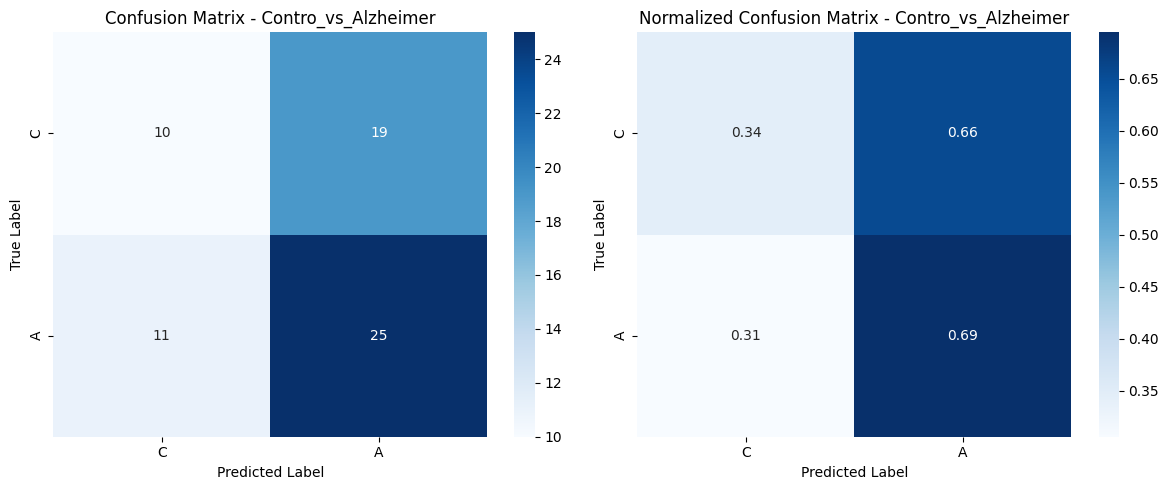


VALUTAZIONE ESPERIMENTO: Contro_vs_Frontotemporal

Evaluating LOSO experiment: Contro_vs_Frontotemporal
Found models directory: experiment_loso/EEGNetv4/Contro_vs_Frontotemporal

Evaluating subject: sub-037
   True: C, Pred: F, Correct: False, Seg_Acc: 0.434

Evaluating subject: sub-038
   True: C, Pred: C, Correct: True, Seg_Acc: 0.705

Evaluating subject: sub-039
   True: C, Pred: C, Correct: True, Seg_Acc: 0.918

Evaluating subject: sub-040
   True: C, Pred: C, Correct: True, Seg_Acc: 0.831

Evaluating subject: sub-041
   True: C, Pred: C, Correct: True, Seg_Acc: 0.998

Evaluating subject: sub-042
   True: C, Pred: F, Correct: False, Seg_Acc: 0.342

Evaluating subject: sub-043
   True: C, Pred: C, Correct: True, Seg_Acc: 0.631

Evaluating subject: sub-044
   True: C, Pred: C, Correct: True, Seg_Acc: 0.596

Evaluating subject: sub-045
   True: C, Pred: F, Correct: False, Seg_Acc: 0.299

Evaluating subject: sub-046
   True: C, Pred: F, Correct: False, Seg_Acc: 0.187

Evaluating subje

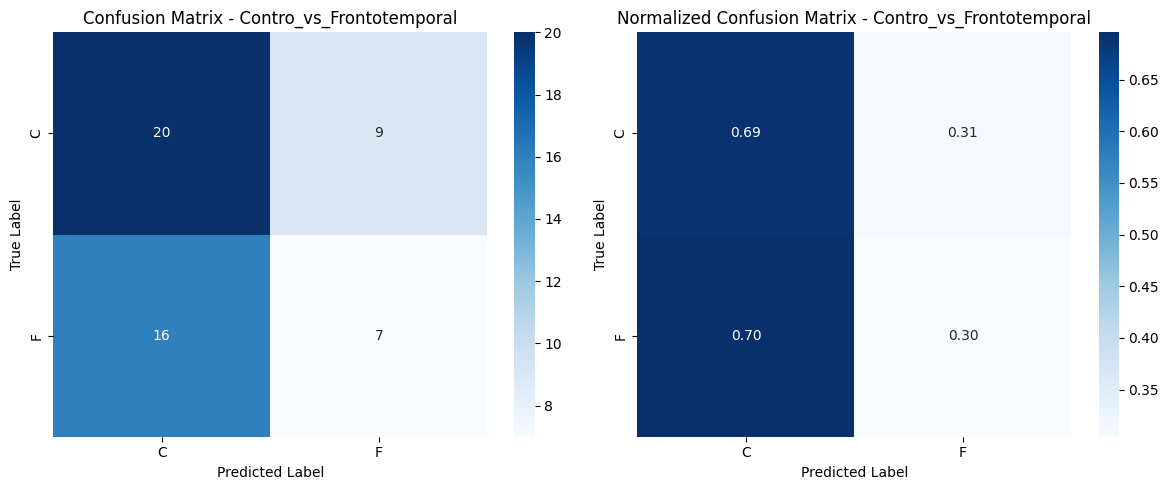


VALUTAZIONE ESPERIMENTO: Frontotemporal_vs_Alzheimer

Evaluating LOSO experiment: Frontotemporal_vs_Alzheimer
Found models directory: experiment_loso/EEGNetv4/Frontotemporal_vs_Alzheimer

Evaluating subject: sub-001
   True: A, Pred: A, Correct: True, Seg_Acc: 0.843

Evaluating subject: sub-002
   True: A, Pred: A, Correct: True, Seg_Acc: 0.987

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 0.864

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 0.503

Evaluating subject: sub-005
   True: A, Pred: F, Correct: False, Seg_Acc: 0.174

Evaluating subject: sub-006
   True: A, Pred: A, Correct: True, Seg_Acc: 0.984

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.738

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.805

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 0.896

Evaluating subject: sub-010
   True: A, Pred: F, Correct: False, Seg_Acc: 0.288

Evaluatin

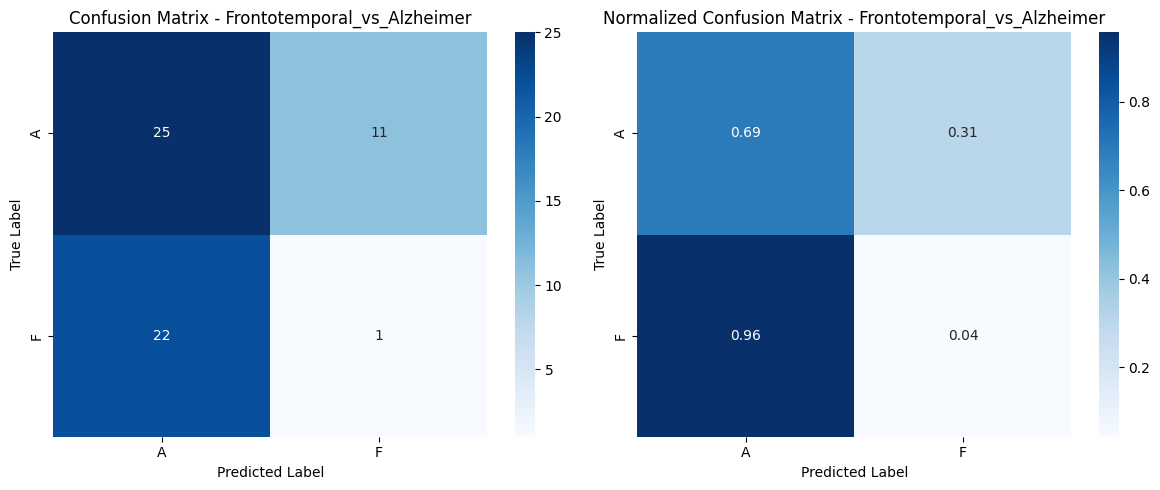


VALUTAZIONE ESPERIMENTO: Contro_vs_Patologici

Evaluating LOSO experiment: Contro_vs_Patologici
Found models directory: experiment_loso/EEGNetv4/Contro_vs_Patologici

Evaluating subject: sub-001
   True: A, Pred: F, Correct: True, Seg_Acc: 0.887

Evaluating subject: sub-002
   True: A, Pred: F, Correct: True, Seg_Acc: 0.995

Evaluating subject: sub-003
   True: A, Pred: F, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-004
   True: A, Pred: F, Correct: True, Seg_Acc: 0.881

Evaluating subject: sub-005
   True: A, Pred: F, Correct: True, Seg_Acc: 0.844

Evaluating subject: sub-006
   True: A, Pred: F, Correct: True, Seg_Acc: 0.940

Evaluating subject: sub-007
   True: A, Pred: F, Correct: True, Seg_Acc: 0.790

Evaluating subject: sub-008
   True: A, Pred: F, Correct: True, Seg_Acc: 0.815

Evaluating subject: sub-009
   True: A, Pred: F, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-010
   True: A, Pred: F, Correct: True, Seg_Acc: 0.580

Evaluating subject: sub-011
   T

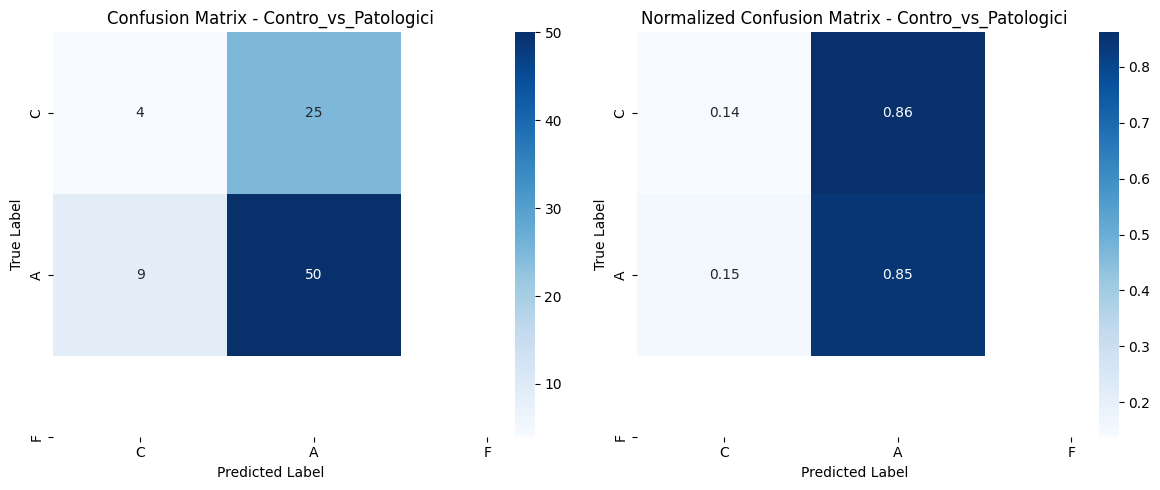

In [12]:
all_results = evaluate_multiple_experiments()

In [13]:
#Salvataggio
experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]

path = "experiment_loso/EEGNetv4/loso_results"
for exp in experiments:
    save_results_to_file(all_results[exp['name']],path,  filename=f"loso_results_{exp['name']}.json")

Risultati salvati in: experiment_loso/EEGNetv4/loso_results/loso_results_Contro_vs_Alzheimer.json
Risultati salvati in: experiment_loso/EEGNetv4/loso_results/loso_results_Contro_vs_Frontotemporal.json
Risultati salvati in: experiment_loso/EEGNetv4/loso_results/loso_results_Frontotemporal_vs_Alzheimer.json
Risultati salvati in: experiment_loso/EEGNetv4/loso_results/loso_results_Contro_vs_Patologici.json


# Secondo modello

In [11]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.callbacks import EarlyStopping

# La configurazione della rete
net = EEGClassifier(
    'Deep4Net',
    callbacks=[
        EarlyStopping(patience=10, threshold=0.001, monitor='valid_loss')
    ],
    module__final_conv_length='auto',
    train_split = ValidSplit(0.3),
    batch_size = 32,
    lr = 0.005,
    max_epochs = 50,
    criterion = CrossEntropyLoss(),
)

In [12]:
label_mapping = {'A': 0, 'C': 1, 'F': 2}

X = combined_epochs.get_data()  # : (n_epochs, n_channels, n_times)

y = np.array([label_mapping[label] for label in patient_labels])

net.fit(X, y)

/Users/bobo/Library/Python/3.9/lib/python/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.2045       0.5159        1.0080  140.3614
      2        1.0640       0.5147        0.9928  177.6192
      3        1.0046       0.5216        0.9893  174.9240
      4        0.9632       0.4917        1.0051  174.4504
      5        0.9238       0.5374        0.9514  178.6639
      6        0.8917       0.5522        0.9208  183.6274
      7        0.8611       0.5799        0.9444  189.6495
      8        0.8269       0.5666        0.9283  197.4696
      9        0.7935       0.6440        0.8156  212.4039
     10        0.7689       0.6376        0.8060  223.0814
     11        0.7435       0.6382        0.8282  226.1276
     12        0.7297       0.6394        0.8000  239.5006
     13        0.7109       0.6015        0.8880  306.1772
     14        0.6981       0.6035        0.8563  222.8624
     15        0.6771       0.6164        0.8673  210.79

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ============================================================================================================================================
  Deep4Net (Deep4Net)                      [1, 19, 1000]             [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 19, 1000]             [1, 19, 1000, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 19, 1000, 1]          [1, 1, 1000, 19]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 19]          [1, 25, 991, 1]           12,150                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 991, 1]           [1, 25, 991, 1]           50                        --
  ├─Expression (conv_nonlin): 1-5          [1, 25, 991, 1]           [1, 25, 991, 1]           --                        --
  ├─MaxPool2d (pool): 1-6                  [1, 25, 991, 1]           [1, 25, 330, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin): 1-7          [1, 25, 330, 1]           [1, 25, 330, 1]           --                        --
  ├─Dropout (drop_2): 1-8                  [1, 25, 330, 1]           [1, 25, 330, 1]           --                        --
  ├─Conv2d (conv_2): 1-9                   [1, 25, 330, 1]           [1, 50, 321, 1]           12,500                    [10, 1]
  ├─BatchNorm2d (bnorm_2): 1-10            [1, 50, 321, 1]           [1, 50, 321, 1]           100                       --
  ├─Expression (nonlin_2): 1-11            [1, 50, 321, 1]           [1, 50, 321, 1]           --                        --
  ├─MaxPool2d (pool_2): 1-12               [1, 50, 321, 1]           [1, 50, 107, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin_2): 1-13       [1, 50, 107, 1]           [1, 50, 107, 1]           --                        --
  ├─Dropout (drop_3): 1-14                 [1, 50, 107, 1]           [1, 50, 107, 1]           --                        --
  ├─Conv2d (conv_3): 1-15                  [1, 50, 107, 1]           [1, 100, 98, 1]           50,000                    [10, 1]
  ├─BatchNorm2d (bnorm_3): 1-16            [1, 100, 98, 1]           [1, 100, 98, 1]           200                       --
  ├─Expression (nonlin_3): 1-17            [1, 100, 98, 1]           [1, 100, 98, 1]           --                        --
  ├─MaxPool2d (pool_3): 1-18               [1, 100, 98, 1]           [1, 100, 32, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin_3): 1-19       [1, 100, 32, 1]           [1, 100, 32, 1]           --                        --
  ├─Dropout (drop_4): 1-20                 [1, 100, 32, 1]           [1, 100, 32, 1]           --                        --
  ├─Conv2d (conv_4): 1-21                  [1, 100, 32, 1]           [1, 200, 23, 1]           200,000                   [10, 1]
  ├─BatchNorm2d (bnorm_4): 1-22            [1, 200, 23, 1]           [1, 200, 23, 1]           400                       --
  ├─Expression (nonlin_4): 1-23            [1, 200, 23, 1]           [1, 200, 23, 1]           --                        --
  ├─MaxPool2d (pool_4): 1-24               [1, 200, 23, 1]           [1, 200, 7, 1]            --                        [3, 1]
  ├─Expression (pool_nonlin_4): 1-25       [1, 200, 7, 1]            [1, 200, 7, 1]            --                        --
  ├─Sequential (final_layer): 1-26         [1, 200, 7, 1]            [1, 3]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1     [1, 200, 7, 1]            [1, 3, 1, 1]              4,203                     [7, 1]
  │ 


VALUTAZIONE ESPERIMENTO: Contro_vs_Alzheimer

Evaluating LOSO experiment: Contro_vs_Alzheimer
Found models directory: experiment_loso/Deep4Net/Contro_vs_Alzheimer

Evaluating subject: sub-001
   True: A, Pred: C, Correct: False, Seg_Acc: 0.110

Evaluating subject: sub-002
   True: A, Pred: A, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 0.968

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-005
   True: A, Pred: A, Correct: True, Seg_Acc: 0.821

Evaluating subject: sub-006
   True: A, Pred: A, Correct: True, Seg_Acc: 0.765

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.953

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.910

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-010
   True: A, Pred: C, Correct: False, Seg_Acc: 0.466

Evaluating subject: sub-011
   Tr

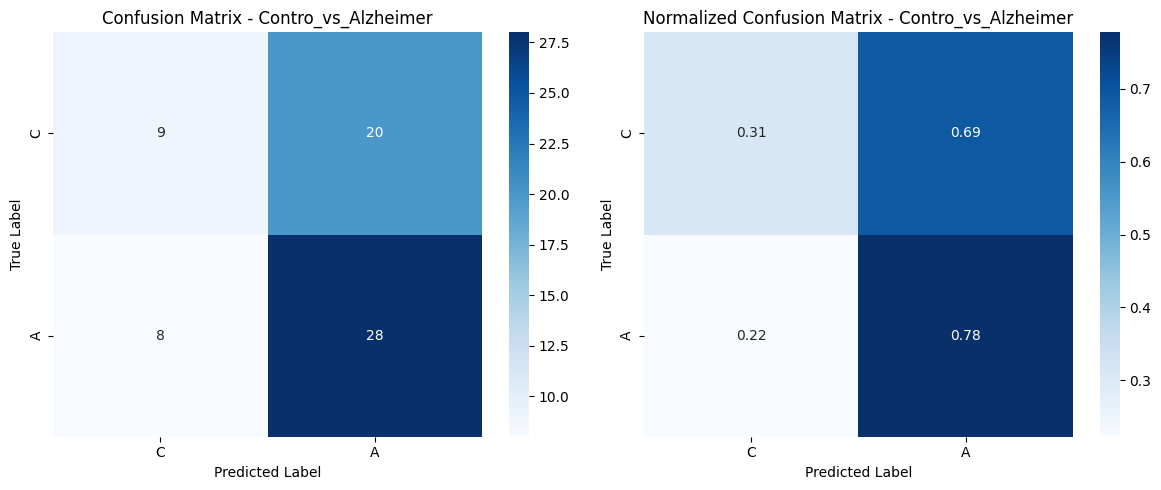


VALUTAZIONE ESPERIMENTO: Contro_vs_Frontotemporal

Evaluating LOSO experiment: Contro_vs_Frontotemporal
Found models directory: experiment_loso/Deep4Net/Contro_vs_Frontotemporal

Evaluating subject: sub-037
   True: C, Pred: F, Correct: False, Seg_Acc: 0.298

Evaluating subject: sub-038
   True: C, Pred: F, Correct: False, Seg_Acc: 0.375

Evaluating subject: sub-039
   True: C, Pred: F, Correct: False, Seg_Acc: 0.012

Evaluating subject: sub-040
   True: C, Pred: C, Correct: True, Seg_Acc: 0.745

Evaluating subject: sub-041
   True: C, Pred: C, Correct: True, Seg_Acc: 0.984

Evaluating subject: sub-042
   True: C, Pred: F, Correct: False, Seg_Acc: 0.404

Evaluating subject: sub-043
   True: C, Pred: F, Correct: False, Seg_Acc: 0.422

Evaluating subject: sub-044
   True: C, Pred: F, Correct: False, Seg_Acc: 0.061

Evaluating subject: sub-045
   True: C, Pred: F, Correct: False, Seg_Acc: 0.097

Evaluating subject: sub-046
   True: C, Pred: C, Correct: True, Seg_Acc: 0.729

Evaluating su

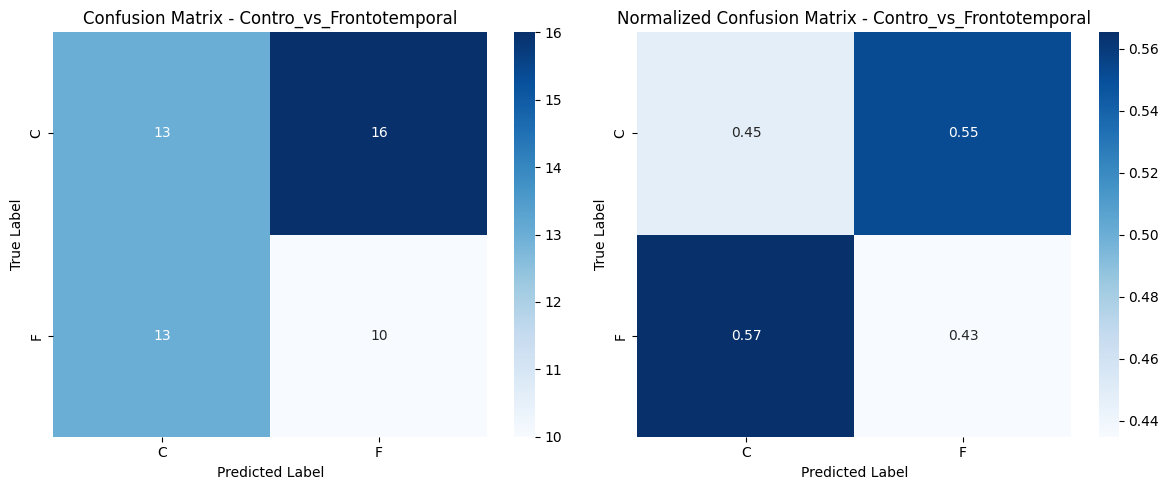


VALUTAZIONE ESPERIMENTO: Frontotemporal_vs_Alzheimer

Evaluating LOSO experiment: Frontotemporal_vs_Alzheimer
Found models directory: experiment_loso/Deep4Net/Frontotemporal_vs_Alzheimer

Evaluating subject: sub-001
   True: A, Pred: A, Correct: True, Seg_Acc: 0.687

Evaluating subject: sub-002
   True: A, Pred: A, Correct: True, Seg_Acc: 0.945

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 0.969

Evaluating subject: sub-005
   True: A, Pred: A, Correct: True, Seg_Acc: 0.856

Evaluating subject: sub-006
   True: A, Pred: F, Correct: False, Seg_Acc: 0.132

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.771

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.662

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 0.580

Evaluating subject: sub-010
   True: A, Pred: F, Correct: False, Seg_Acc: 0.265

Evaluatin

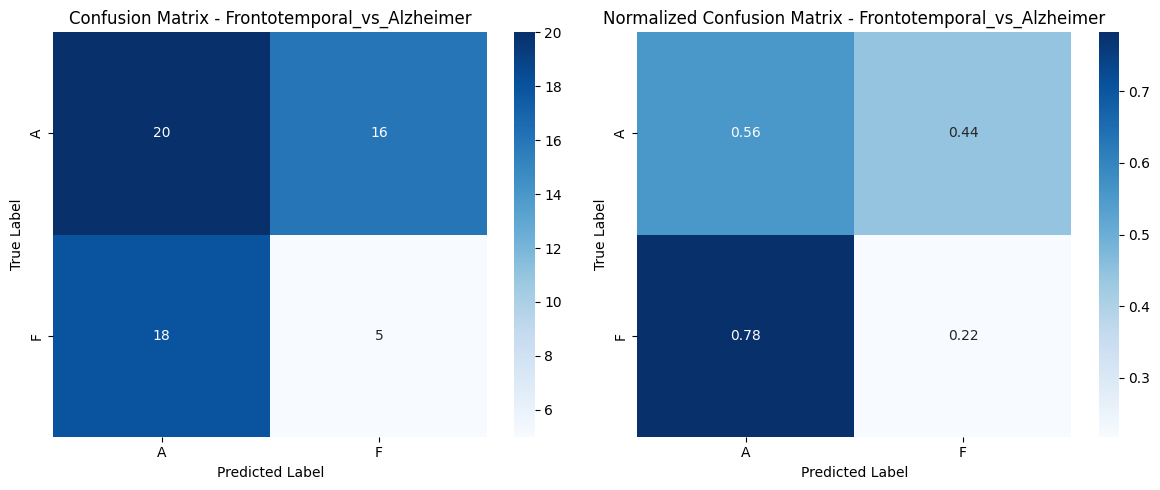


VALUTAZIONE ESPERIMENTO: Contro_vs_Patologici

Evaluating LOSO experiment: Contro_vs_Patologici
Found models directory: experiment_loso/Deep4Net/Contro_vs_Patologici

Evaluating subject: sub-001
   True: A, Pred: F, Correct: True, Seg_Acc: 0.937

Evaluating subject: sub-002
   True: A, Pred: F, Correct: True, Seg_Acc: 0.987

Evaluating subject: sub-003
   True: A, Pred: F, Correct: True, Seg_Acc: 0.974

Evaluating subject: sub-004
   True: A, Pred: F, Correct: True, Seg_Acc: 0.523

Evaluating subject: sub-005
   True: A, Pred: C, Correct: False, Seg_Acc: 0.305

Evaluating subject: sub-006
   True: A, Pred: F, Correct: True, Seg_Acc: 0.859

Evaluating subject: sub-007
   True: A, Pred: C, Correct: False, Seg_Acc: 0.036

Evaluating subject: sub-008
   True: A, Pred: F, Correct: True, Seg_Acc: 0.512

Evaluating subject: sub-009
   True: A, Pred: F, Correct: True, Seg_Acc: 0.964

Evaluating subject: sub-010
   True: A, Pred: C, Correct: False, Seg_Acc: 0.441

Evaluating subject: sub-011
 

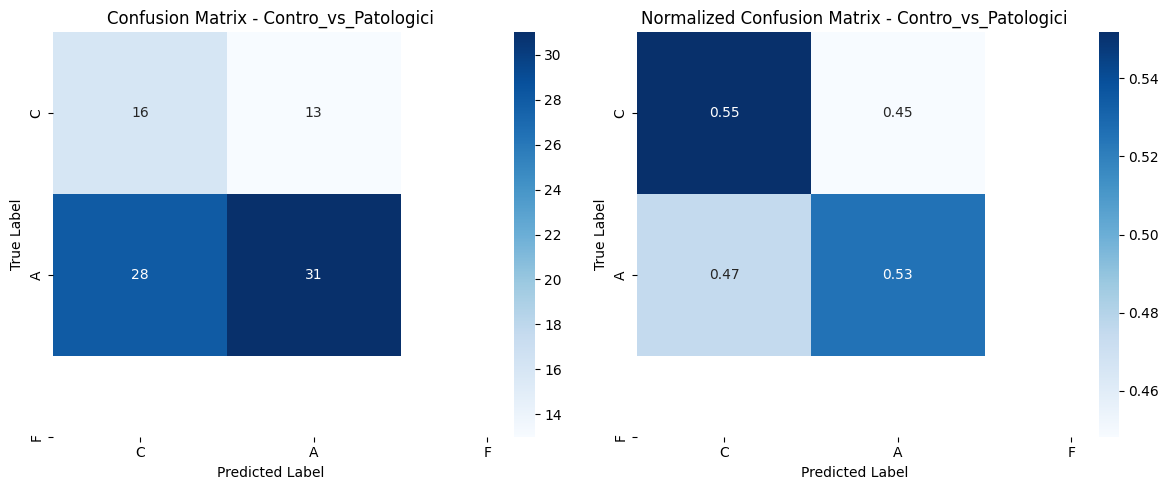

In [19]:
memmap_dir = "experiment_loso/Deep4Net" # esperimento con 
all_results = evaluate_multiple_experiments()

In [20]:
#Salvataggio
experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]

path = "experiment_loso/Deep4Net/loso_results"
for exp in experiments:
    save_results_to_file(all_results[exp['name']],path,  filename=f"loso_results_{exp['name']}.json")

Risultati salvati in: experiment_loso/Deep4Net/loso_results/loso_results_Contro_vs_Alzheimer.json
Risultati salvati in: experiment_loso/Deep4Net/loso_results/loso_results_Contro_vs_Frontotemporal.json
Risultati salvati in: experiment_loso/Deep4Net/loso_results/loso_results_Frontotemporal_vs_Alzheimer.json
Risultati salvati in: experiment_loso/Deep4Net/loso_results/loso_results_Contro_vs_Patologici.json


In [ ]:
# Boxplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

def load_all_results(base_dirs):
    """
    Carica tutti i risultati JSON da multiple directory di esperimenti
    
    Args:
        base_dirs (dict): Dizionario con nome_modello: path_directory
                         es. {'EEGNetv4': 'experiment_loso/EEGNetv4/loso_results',
                              'Deep4Net': 'experiment_loso/Deep4Net/loso_results'}
    
    Returns:
        dict: Risultati organizzati per modello ed esperimento
    """
    all_results = {}
    
    for model_name, results_dir in base_dirs.items():
        all_results[model_name] = {}
        
        if os.path.exists(results_dir):
            for file in os.listdir(results_dir):
                if file.endswith('.json') and file.startswith('loso_results_'):
                    # Estrai il nome dell'esperimento dal filename
                    exp_name = file.replace('loso_results_', '').replace('.json', '')
                    
                    with open(os.path.join(results_dir, file), 'r') as f:
                        data = json.load(f)
                        all_results[model_name][exp_name] = data
        else:
            print(f"Directory non trovata: {results_dir}")
    
    return all_results

def create_comparison_dataframes(all_results):
    """
    Crea DataFrames per il confronto delle metriche
    
    Returns:
        tuple: (df_subjects, df_segments) - DataFrames per soggetti e segmenti
    """
    
    # Liste per raccogliere i dati
    subject_data = []
    segment_data = []
    
    for model_name, model_results in all_results.items():
        for exp_name, exp_data in model_results.items():
            
            # Dati sui soggetti (accuracy individuali)
            for subject_result in exp_data['subject_results']:
                subject_data.append({
                    'Model': model_name,
                    'Experiment': exp_name,
                    'Subject': subject_result['subject'],
                    'Accuracy': 1.0 if subject_result['correct'] else 0.0,
                    'Segment_Accuracy': subject_result['segment_accuracy'],
                    'N_Segments': subject_result['n_segments']
                })
            
            # Dati aggregati per esperimento
            segment_data.append({
                'Model': model_name,
                'Experiment': exp_name,
                'Segment_Accuracy': exp_data['segments']['accuracy'],
                'Segment_Accuracy_Std': exp_data['segments']['accuracy_std'],
                'Subject_Accuracy': exp_data['subjects']['accuracy'],
                'Subject_Accuracy_Std': exp_data['subjects']['accuracy_std'],
                'Precision': exp_data['subjects']['precision'],
                'Recall': exp_data['subjects']['recall'],
                'F1_Score': exp_data['subjects']['f1_score'],
                'N_Subjects': exp_data['n_subjects']
            })
    
    df_subjects = pd.DataFrame(subject_data)
    df_segments = pd.DataFrame(segment_data)
    
    return df_subjects, df_segments

def plot_subject_accuracy_boxplots(df_subjects, save_path=None):
    """
    Crea boxplot per confrontare l'accuracy dei soggetti tra modelli ed esperimenti
    """
    plt.figure(figsize=(15, 10))
    
    # Boxplot principale
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df_subjects, x='Experiment', y='Accuracy', hue='Model')
    plt.title('Subject-Level Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Subject Accuracy (0/1)')
    
    # Boxplot per segment accuracy
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df_subjects, x='Experiment', y='Segment_Accuracy', hue='Model')
    plt.title('Segment-Level Accuracy per Subject')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Segment Accuracy')
    
    # Violin plot per una vista più dettagliata
    plt.subplot(2, 2, 3)
    sns.violinplot(data=df_subjects, x='Experiment', y='Accuracy', hue='Model')
    plt.title('Subject Accuracy Distribution (Violin Plot)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Subject Accuracy (0/1)')
    
    # Strip plot per vedere i punti individuali
    plt.subplot(2, 2, 4)
    sns.stripplot(data=df_subjects, x='Experiment', y='Segment_Accuracy', hue='Model', 
                  dodge=True, alpha=0.7, size=4)
    plt.title('Individual Subject Segment Accuracies')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Segment Accuracy')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_metrics_comparison(df_segments, save_path=None):
    """
    Crea boxplot per confrontare tutte le metriche aggregate
    """
    # Trasforma i dati in formato long per il plotting
    metrics_data = []
    for _, row in df_segments.iterrows():
        for metric in ['Subject_Accuracy', 'Precision', 'Recall', 'F1_Score']:
            metrics_data.append({
                'Model': row['Model'],
                'Experiment': row['Experiment'],
                'Metric': metric,
                'Value': row[metric]
            })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    plt.figure(figsize=(16, 10))
    
    # Plot principale con tutte le metriche
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df_metrics, x='Experiment', y='Value', hue='Model')
    plt.title('All Metrics Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Metric Value')
    plt.ylim(0, 1.1)
    
    # Plot separato per ogni metrica
    metrics = ['Subject_Accuracy', 'Precision', 'Recall', 'F1_Score']
    for i, metric in enumerate(metrics[:3]):
        plt.subplot(2, 2, i+2)
        metric_data = df_metrics[df_metrics['Metric'] == metric]
        sns.barplot(data=metric_data, x='Experiment', y='Value', hue='Model')
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric.replace('_', ' '))
        plt.ylim(0, 1.1)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def create_summary_statistics(df_subjects, df_segments):
    """
    Crea statistiche riassuntive per il confronto
    """
    print("="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # Statistiche per soggetti
    print("\n📊 SUBJECT-LEVEL ACCURACY STATISTICS:")
    summary_subjects = df_subjects.groupby(['Model', 'Experiment'])['Accuracy'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(3)
    print(summary_subjects)
    
    # Statistiche per segmenti
    print("\n📊 EXPERIMENT-LEVEL METRICS:")
    summary_segments = df_segments.groupby('Model')[['Subject_Accuracy', 'Precision', 'Recall', 'F1_Score']].agg([
        'mean', 'std', 'min', 'max'
    ]).round(3)
    print(summary_segments)
    
    # Test statistici (se hai scipy)
    try:
        from scipy import stats
        
        print("\n📊 STATISTICAL TESTS (Mann-Whitney U):")
        
        models = df_subjects['Model'].unique()
        if len(models) == 2:
            for exp in df_subjects['Experiment'].unique():
                exp_data = df_subjects[df_subjects['Experiment'] == exp]
                
                if len(exp_data) > 0:
                    model1_data = exp_data[exp_data['Model'] == models[0]]['Accuracy']
                    model2_data = exp_data[exp_data['Model'] == models[1]]['Accuracy']
                    
                    if len(model1_data) > 0 and len(model2_data) > 0:
                        statistic, p_value = stats.mannwhitneyu(
                            model1_data, model2_data, alternative='two-sided'
                        )
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                        
                        print(f"{exp}: {models[0]} vs {models[1]}")
                        print(f"  U-statistic: {statistic:.3f}, p-value: {p_value:.3f} {significance}")
    
    except ImportError:
        print("Scipy non disponibile per i test statistici")
    
    return summary_subjects, summary_segments

def comprehensive_comparison_analysis():
    """
    Funzione principale per l'analisi completa dei risultati
    """
    # Configura i path dei risultati
    base_dirs = {
        'EEGNetv4': 'experiment_loso/EEGNetv4/loso_results',
        'Deep4Net': 'experiment_loso/Deep4Net/loso_results'
    }
    
    # Carica tutti i risultati
    print("Caricamento risultati...")
    all_results = load_all_results(base_dirs)
    
    # Crea DataFrames
    print("Creazione DataFrames...")
    df_subjects, df_segments = create_comparison_dataframes(all_results)
    
    # Crea i plot
    print("Generazione boxplot...")
    plot_subject_accuracy_boxplots(df_subjects, 'boxplot_subject_accuracy.png')
    plot_metrics_comparison(df_segments, 'boxplot_metrics_comparison.png')
    
    # Statistiche riassuntive
    summary_subjects, summary_segments = create_summary_statistics(df_subjects, df_segments)
    
    return df_subjects, df_segments, summary_subjects, summary_segments


Caricamento risultati...
Creazione DataFrames...
Generazione boxplot...


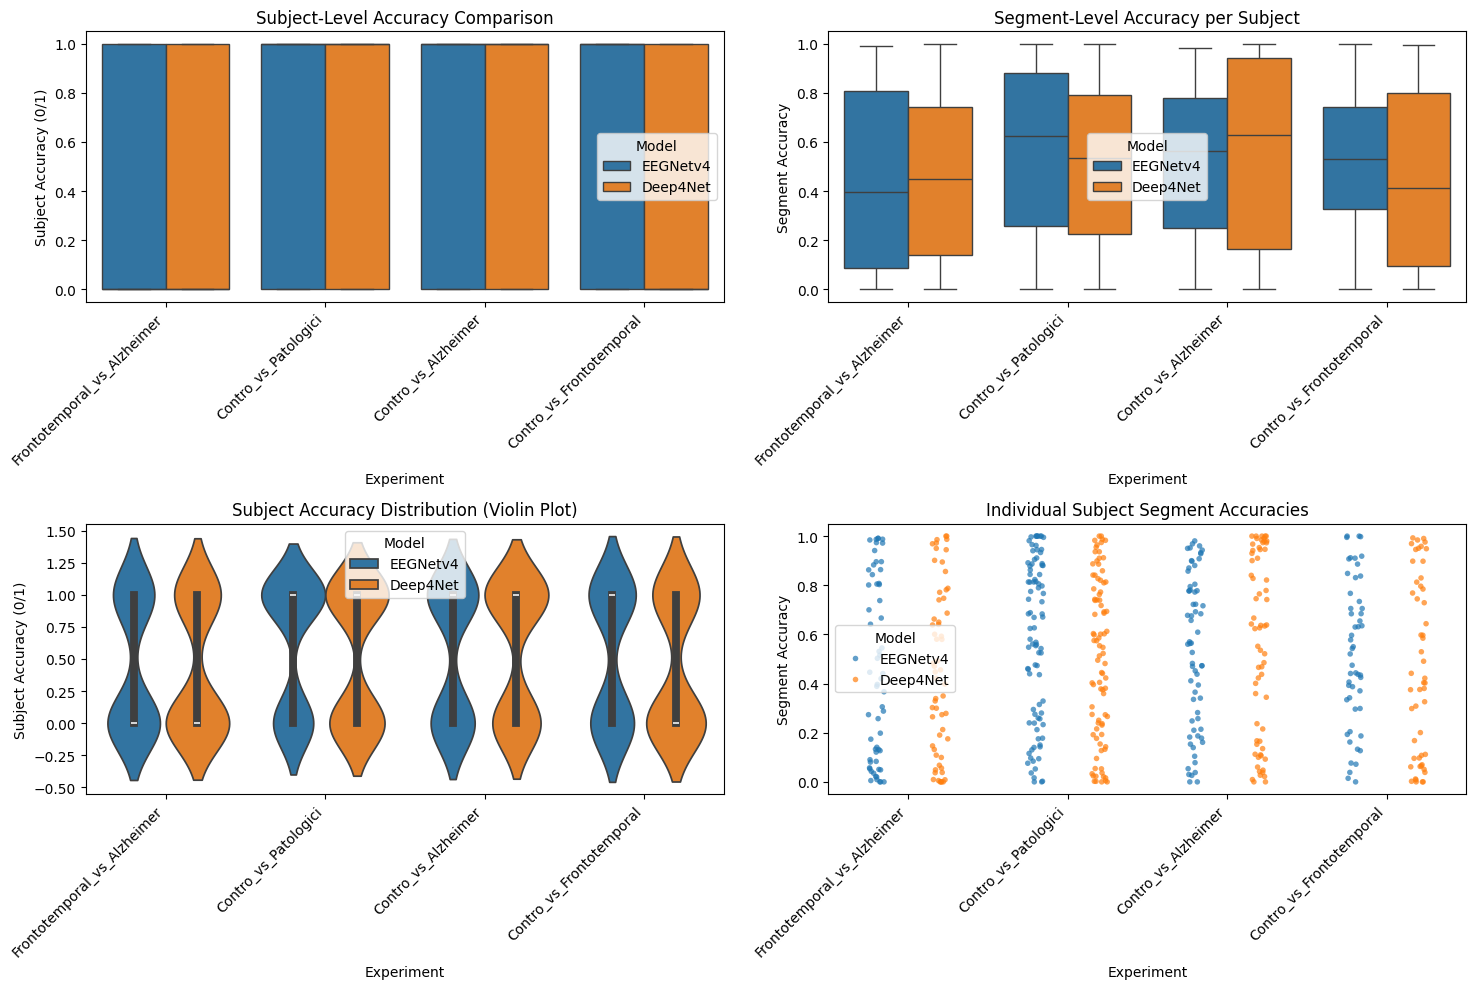

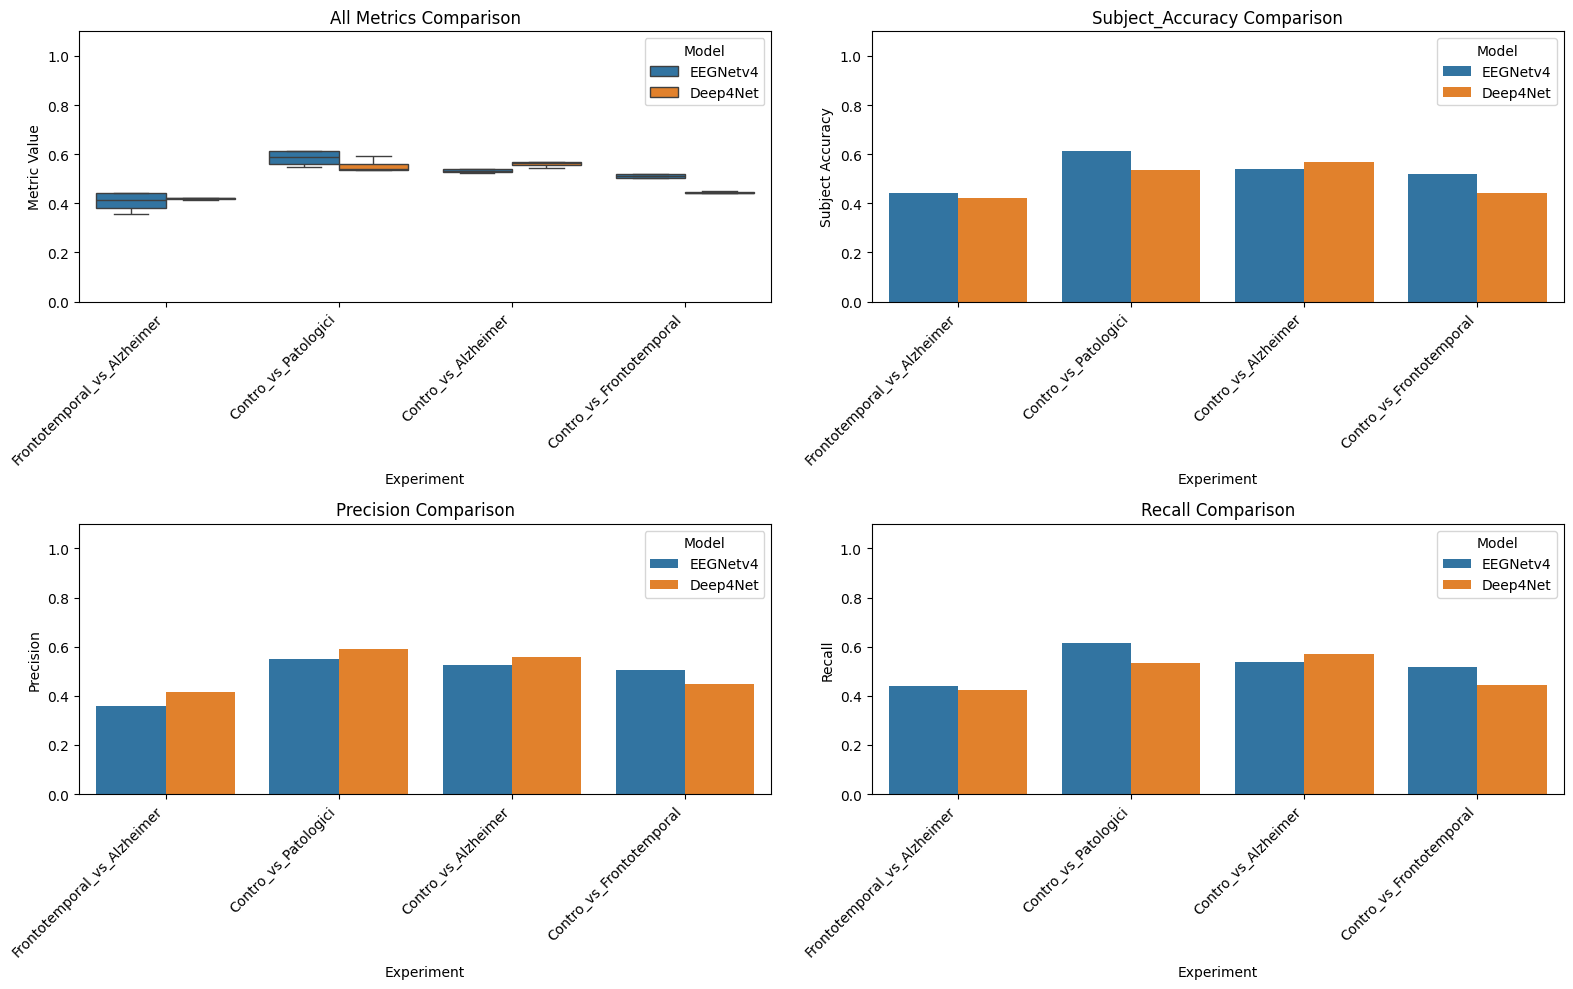

SUMMARY STATISTICS

📊 SUBJECT-LEVEL ACCURACY STATISTICS:
                                      count   mean    std  min  max
Model    Experiment                                                
Deep4Net Contro_vs_Alzheimer             65  0.569  0.499  0.0  1.0
         Contro_vs_Frontotemporal        52  0.442  0.502  0.0  1.0
         Contro_vs_Patologici            88  0.534  0.502  0.0  1.0
         Frontotemporal_vs_Alzheimer     59  0.424  0.498  0.0  1.0
EEGNetv4 Contro_vs_Alzheimer             65  0.538  0.502  0.0  1.0
         Contro_vs_Frontotemporal        52  0.519  0.505  0.0  1.0
         Contro_vs_Patologici            88  0.614  0.490  0.0  1.0
         Frontotemporal_vs_Alzheimer     59  0.441  0.501  0.0  1.0

📊 EXPERIMENT-LEVEL METRICS:
         Subject_Accuracy                      Precision                       \
                     mean    std    min    max      mean    std    min    max   
Model                                                                   

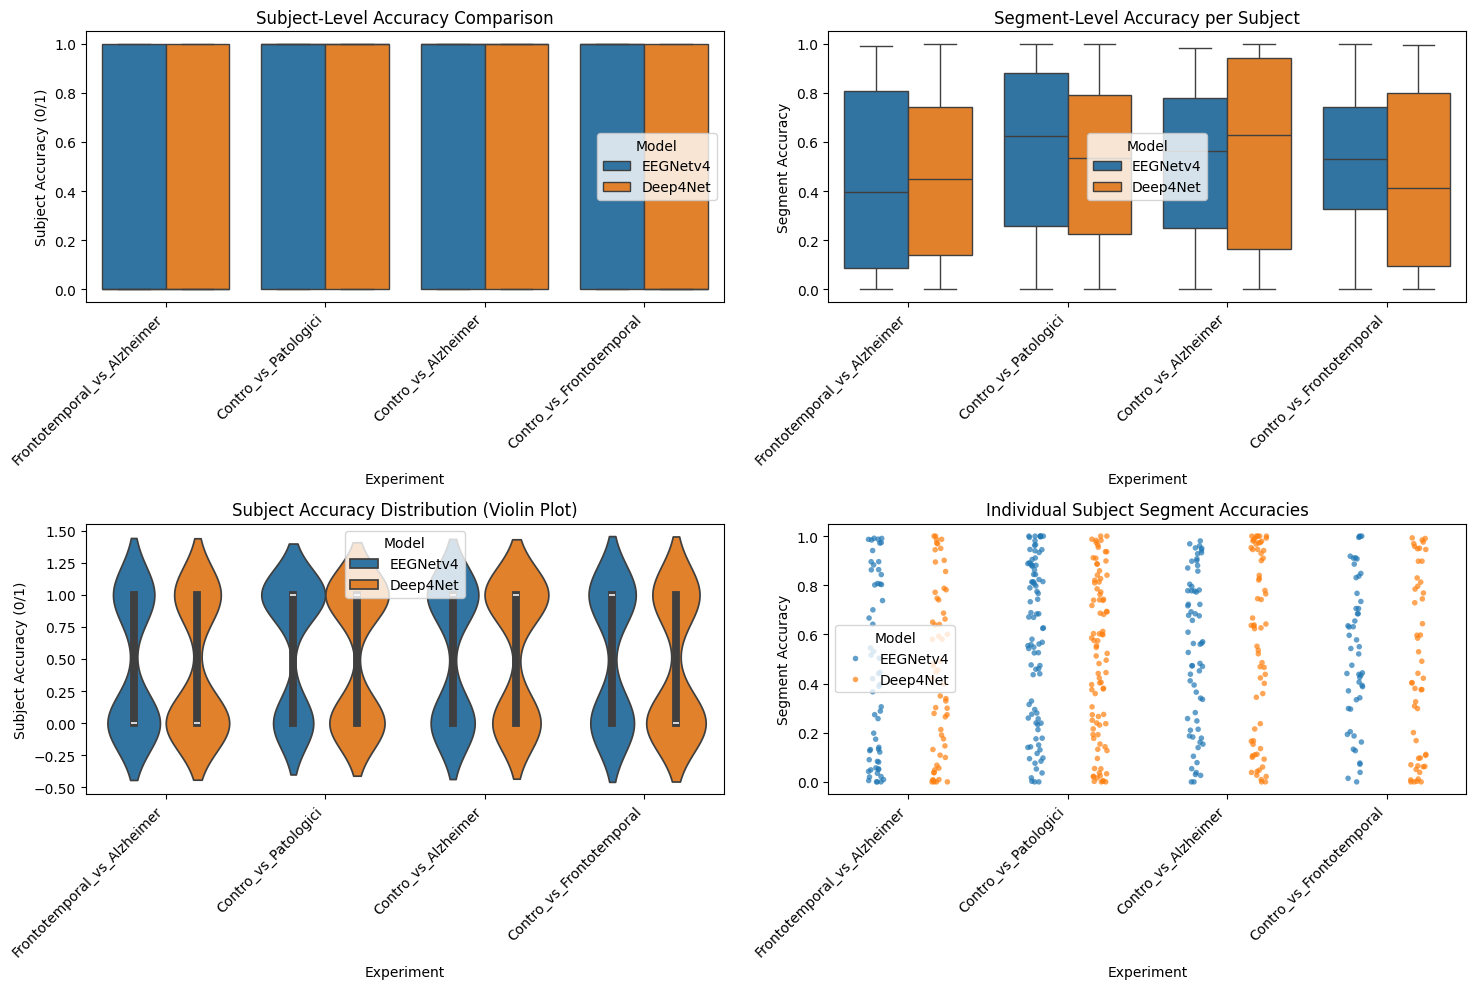

In [ ]:
# Analisi completa
df_subjects, df_segments, summary_subjects, summary_segments = comprehensive_comparison_analysis()

base_dirs = {
    'EEGNetv4': 'experiment_loso/EEGNetv4/loso_results',
    'Deep4Net': 'experiment_loso/Deep4Net/loso_results'
}
all_results = load_all_results(base_dirs)
df_subjects, df_segments = create_comparison_dataframes(all_results)
plot_subject_accuracy_boxplots(df_subjects)

## Analisi del Bias dovuto a Dataset Sbilanciato
 
Questo codice analizza se i modelli stanno semplicemente sfruttando lo sbilanciamento del dataset invece di imparare pattern reali nei dati EEG.

In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency

def analyze_class_distribution(df, true_labels):
    """Analizza la distribuzione delle classi nel dataset"""
    
    print("="*60)
    print("ANALISI DISTRIBUZIONE CLASSI")
    print("="*60)
    
    # Conta le classi per ogni esperimento
    experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]
    
    distribution_info = {}
    
    for exp in experiments:
        # Filtra soggetti per questo esperimento
        exp_subjects = {s: l for s, l in true_labels.items() if l in exp['classes']}
        
        # Conta le classi originali
        class_counts = Counter(exp_subjects.values())
        
        # Mappa alle classi numeriche per l'esperimento
        numeric_counts = {}
        for class_label, numeric_label in exp['label_mapping'].items():
            if class_label in class_counts:
                if numeric_label not in numeric_counts:
                    numeric_counts[numeric_label] = 0
                numeric_counts[numeric_label] += class_counts[class_label]
        
        total = sum(numeric_counts.values())
        percentages = {k: (v/total)*100 for k, v in numeric_counts.items()}
        
        # Calcola chance level (accuracy ottenibile classificando sempre la classe maggioritaria)
        majority_class_count = max(numeric_counts.values())
        chance_level = (majority_class_count / total) * 100
        
        distribution_info[exp['name']] = {
            'class_counts': class_counts,
            'numeric_counts': numeric_counts,
            'percentages': percentages,
            'total': total,
            'chance_level': chance_level,
            'classes': exp['classes'],
            'label_mapping': exp['label_mapping']
        }
        
        print(f"\n- {exp['name']}:")
        print(f"   Classi originali: {dict(class_counts)}")
        print(f"   Classi numeriche: {dict(numeric_counts)}")
        print(f"   Percentuali: {dict(percentages)}")
        print(f"   Chance Level (majority class): {chance_level:.1f}%")
        print(f"   Sbilanciamento: {max(percentages.values())/min(percentages.values()):.2f}:1")
    
    return distribution_info

def analyze_prediction_patterns(results_data, distribution_info):
    """Analizza i pattern di predizione per identificare possibili bias"""
    
    print("\n" + "="*60)
    print("ANALISI PATTERN DI PREDIZIONE")
    print("="*60)
    
    bias_analysis = {}
    
    for exp_name, exp_results in results_data.items():
        if exp_name not in distribution_info:
            continue
            
        print(f"\n- {exp_name}:")
        
        dist_info = distribution_info[exp_name]
        subject_results = exp_results['subject_results']
        
        # Conta le predizioni effettuate dal modello
        pred_counts = Counter([r['pred_label'] for r in subject_results])
        true_counts = Counter([r['true_label'] for r in subject_results])
        
        # Mappa alle classi numeriche
        pred_numeric = {}
        true_numeric = {}
        
        for label, count in pred_counts.items():
            numeric_label = dist_info['label_mapping'].get(label, label)
            if numeric_label not in pred_numeric:
                pred_numeric[numeric_label] = 0
            pred_numeric[numeric_label] += count
        
        for label, count in true_counts.items():
            numeric_label = dist_info['label_mapping'].get(label, label)
            if numeric_label not in true_numeric:
                true_numeric[numeric_label] = 0
            true_numeric[numeric_label] += count
        
        total_preds = sum(pred_numeric.values())
        pred_percentages = {k: (v/total_preds)*100 for k, v in pred_numeric.items()}
        
        # Confronta con la distribuzione reale
        print(f"   Distribuzione reale: {dict(true_counts)}")
        print(f"   Predizioni modello: {dict(pred_counts)}")
        print(f"   % Predizioni: {dict(pred_percentages)}")
        print(f"   % Reali: {dict(dist_info['percentages'])}")
        
        # Calcola se il modello favorisce la classe maggioritaria
        majority_class = max(dist_info['numeric_counts'], key=dist_info['numeric_counts'].get)
        majority_pred_rate = pred_percentages.get(majority_class, 0)
        majority_real_rate = dist_info['percentages'][majority_class]
        
        bias_score = majority_pred_rate - majority_real_rate
        
        print(f"   Classe maggioritaria: {majority_class}")
        print(f"   Bias score: {bias_score:.1f}% (>20% indica possibile bias)")
        
        # Test chi-quadro per verificare se le predizioni seguono la distribuzione reale
        try:
            observed = list(pred_numeric.values())
            expected_props = [dist_info['numeric_counts'][k]/dist_info['total'] for k in pred_numeric.keys()]
            expected = [prop * total_preds for prop in expected_props]
            
            if len(observed) >= 2 and all(e >= 5 for e in expected):
                chi2, p_value = chi2_contingency([observed, expected])[:2]
                print(f"   Chi-quadro test p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("   !  Le predizioni differiscono significativamente dalla distribuzione reale")
                else:
                    print("    Le predizioni seguono la distribuzione reale")
        except:
            print("   Chi-quadro test non applicabile")
        
        # Analisi accuracy per classe
        accuracy_by_class = {}
        for class_label in set([r['true_label'] for r in subject_results]):
            class_subjects = [r for r in subject_results if r['true_label'] == class_label]
            correct = sum(1 for r in class_subjects if r['correct'])
            total = len(class_subjects)
            accuracy_by_class[class_label] = (correct/total)*100 if total > 0 else 0
        
        print(f"   Accuracy per classe: {dict(accuracy_by_class)}")
        
        # Identifica possibile bias
        is_biased = False
        bias_reasons = []
        
        if bias_score > 20:
            is_biased = True
            bias_reasons.append("Favorisce eccessivamente la classe maggioritaria")
        
        min_class_acc = min(accuracy_by_class.values())
        max_class_acc = max(accuracy_by_class.values())
        if max_class_acc - min_class_acc > 40:
            is_biased = True
            bias_reasons.append("Grande differenza di accuracy tra classi")
        
        if majority_pred_rate > 80 and len(pred_numeric) > 1:
            is_biased = True
            bias_reasons.append("Predice quasi sempre la stessa classe")
        
        bias_analysis[exp_name] = {
            'is_biased': is_biased,
            'bias_reasons': bias_reasons,
            'bias_score': bias_score,
            'accuracy_by_class': accuracy_by_class,
            'pred_distribution': pred_percentages,
            'real_distribution': dist_info['percentages'],
            'chance_level': dist_info['chance_level'],
            'actual_accuracy': exp_results['subjects']['accuracy'] * 100
        }
        
        if is_biased:
            print(f"   ! POSSIBILE BIAS: {', '.join(bias_reasons)}")
        else:
            print(f"    Nessun bias evidente rilevato")
    
    return bias_analysis

def plot_bias_analysis(bias_analysis, save_path=None):
    """Crea visualizzazioni per l'analisi del bias"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Confronto accuracy vs chance level
    exp_names = list(bias_analysis.keys())
    actual_acc = [bias_analysis[exp]['actual_accuracy'] for exp in exp_names]
    chance_levels = [bias_analysis[exp]['chance_level'] for exp in exp_names]
    
    x = np.arange(len(exp_names))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, actual_acc, width, label='Actual Accuracy', alpha=0.8)
    axes[0, 0].bar(x + width/2, chance_levels, width, label='Chance Level', alpha=0.8)
    axes[0, 0].set_xlabel('Experiments')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Actual Accuracy vs Chance Level')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([name.replace('_', '_\n') for name in exp_names], rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Bias score
    bias_scores = [bias_analysis[exp]['bias_score'] for exp in exp_names]
    colors = ['red' if score > 20 else 'orange' if score > 10 else 'green' for score in bias_scores]
    
    axes[0, 1].bar(range(len(exp_names)), bias_scores, color=colors, alpha=0.7)
    axes[0, 1].axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Bias threshold')
    axes[0, 1].axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='Warning threshold')
    axes[0, 1].set_xlabel('Experiments')
    axes[0, 1].set_ylabel('Bias Score (%)')
    axes[0, 1].set_title('Majority Class Bias Score')
    axes[0, 1].set_xticks(range(len(exp_names)))
    axes[0, 1].set_xticklabels([name.replace('_', '_\n') for name in exp_names], rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy difference between classes
    acc_diffs = []
    for exp in exp_names:
        class_accs = list(bias_analysis[exp]['accuracy_by_class'].values())
        if len(class_accs) >= 2:
            acc_diffs.append(max(class_accs) - min(class_accs))
        else:
            acc_diffs.append(0)
    
    colors = ['red' if diff > 40 else 'orange' if diff > 20 else 'green' for diff in acc_diffs]
    
    axes[1, 0].bar(range(len(exp_names)), acc_diffs, color=colors, alpha=0.7)
    axes[1, 0].axhline(y=40, color='red', linestyle='--', alpha=0.7, label='High bias threshold')
    axes[1, 0].axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Moderate bias threshold')
    axes[1, 0].set_xlabel('Experiments')
    axes[1, 0].set_ylabel('Accuracy Difference (%)')
    axes[1, 0].set_title('Accuracy Difference Between Classes')
    axes[1, 0].set_xticks(range(len(exp_names)))
    axes[1, 0].set_xticklabels([name.replace('_', '_\n') for name in exp_names], rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Confusion matrix style plot per il caso più problematico
    most_biased_exp = max(bias_analysis.keys(), key=lambda x: bias_analysis[x]['bias_score'])
    
    pred_dist = bias_analysis[most_biased_exp]['pred_distribution']
    real_dist = bias_analysis[most_biased_exp]['real_distribution']
    
    classes = sorted(set(list(pred_dist.keys()) + list(real_dist.keys())))
    pred_values = [pred_dist.get(c, 0) for c in classes]
    real_values = [real_dist.get(c, 0) for c in classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, real_values, width, label='Real Distribution', alpha=0.8)
    axes[1, 1].bar(x + width/2, pred_values, width, label='Prediction Distribution', alpha=0.8)
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Percentage')
    axes[1, 1].set_title(f'Distribution Comparison\n{most_biased_exp}')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([f'Class {c}' for c in classes])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def generate_bias_report(bias_analysis):
    """Genera un report completo sull'analisi del bias"""
    
    print("\n" + "="*80)
    print("REPORT FINALE ANALISI BIAS")
    print("="*80)
    
    total_experiments = len(bias_analysis)
    biased_experiments = sum(1 for exp in bias_analysis.values() if exp['is_biased'])
    
    print(f"\nRiepilogo generale:")
    print(f"• Esperimenti totali: {total_experiments}")
    print(f"• Esperimenti con possibile bias: {biased_experiments}")
    print(f"• Percentuale esperimenti puliti: {((total_experiments-biased_experiments)/total_experiments)*100:.1f}%")
    
    print(f"\nDettaglio per esperimento:")
    
    for exp_name, analysis in bias_analysis.items():
        status = "! BIAS RILEVATO" if analysis['is_biased'] else "PULITO"
        
        print(f"\n- {exp_name}: {status}")
        print(f"   Accuracy: {analysis['actual_accuracy']:.1f}% (Chance level: {analysis['chance_level']:.1f}%)")
        print(f"   Miglioramento su chance: {analysis['actual_accuracy'] - analysis['chance_level']:.1f}%")
        print(f"   Bias score: {analysis['bias_score']:.1f}%")
        
        if analysis['is_biased']:
            print(f"   Motivi bias: {', '.join(analysis['bias_reasons'])}")
        
        print(f"   Accuracy per classe: {dict(analysis['accuracy_by_class'])}")
        
        # Valutazione della validità del risultato
        improvement = analysis['actual_accuracy'] - analysis['chance_level']
        if improvement > 15:
            validity = "Alta"
        elif improvement > 5:
            validity = "Media"
        else:
            validity = "Bassa"
        
        bias_level = "Alto" if analysis['bias_score'] > 20 else "Medio" if analysis['bias_score'] > 10 else "Basso"
        
        print(f"   Validità risultato: {validity} (miglioramento: {improvement:.1f}%, bias: {bias_level})")
    
    # Raccomandazioni
    print(f"\nRACCOMANDAZIONI:")
    
    problematic_exps = [name for name, analysis in bias_analysis.items() if analysis['is_biased']]
    
    if problematic_exps:
        print(f"• Esperimenti da considerare con cautela: {', '.join(problematic_exps)}")
        print(f"• Considera di bilanciare il dataset o usare metriche come F1-score e AUC")
        print(f"• Valuta l'uso di tecniche come SMOTE per il bilanciamento")
        print(f"• Analizza la matrice di confusione per confermare i pattern")
    else:
        print(f"• Tutti gli esperimenti mostrano pattern di predizione sani")
        print(f"• I risultati sono probabilmente dovuti a apprendimento di pattern reali")
    
    return {
        'total_experiments': total_experiments,
        'biased_experiments': biased_experiments,
        'clean_percentage': ((total_experiments-biased_experiments)/total_experiments)*100,
        'problematic_experiments': problematic_exps
    }

# Funzione principale per l'analisi completa del bias
def comprehensive_bias_analysis(base_dirs, true_labels):
    """
    Esegue l'analisi completa del bias per tutti i modelli
    
    Args:
        base_dirs (dict): Dizionario con percorsi dei risultati per modello
        true_labels (dict): Dizionario con le etichette vere dei soggetti
    """
    
    all_bias_results = {}
    
    for model_name, results_dir in base_dirs.items():
        print(f"\n{'='*80}")
        print(f"ANALISI BIAS PER MODELLO: {model_name}")
        print("="*80)
        
        # Carica i risultati per questo modello
        model_results = {}
        if os.path.exists(results_dir):
            for file in os.listdir(results_dir):
                if file.endswith('.json') and file.startswith('loso_results_'):
                    exp_name = file.replace('loso_results_', '').replace('.json', '')
                    with open(os.path.join(results_dir, file), 'r') as f:
                        model_results[exp_name] = json.load(f)
        
        if not model_results:
            print(f"Nessun risultato trovato per {model_name}")
            continue
        
        # Analizza distribuzione classi
        distribution_info = analyze_class_distribution(df, true_labels)
        
        # Analizza pattern di predizione
        bias_analysis = analyze_prediction_patterns(model_results, distribution_info)
        
        # Crea visualizzazioni
        plot_bias_analysis(bias_analysis, f'bias_analysis_{model_name}.png')
        
        # Genera report
        report_summary = generate_bias_report(bias_analysis)
        
        all_bias_results[model_name] = {
            'bias_analysis': bias_analysis,
            'report_summary': report_summary,
            'distribution_info': distribution_info
        }
    
    return all_bias_results




ANALISI BIAS PER MODELLO: EEGNetv4
ANALISI DISTRIBUZIONE CLASSI

- Contro_vs_Alzheimer:
   Classi originali: {'A': 36, 'C': 29}
   Classi numeriche: {0: 29, 1: 36}
   Percentuali: {0: 44.61538461538462, 1: 55.38461538461539}
   Chance Level (majority class): 55.4%
   Sbilanciamento: 1.24:1

- Contro_vs_Frontotemporal:
   Classi originali: {'C': 29, 'F': 23}
   Classi numeriche: {0: 29, 1: 23}
   Percentuali: {0: 55.769230769230774, 1: 44.230769230769226}
   Chance Level (majority class): 55.8%
   Sbilanciamento: 1.26:1

- Frontotemporal_vs_Alzheimer:
   Classi originali: {'A': 36, 'F': 23}
   Classi numeriche: {0: 36, 1: 23}
   Percentuali: {0: 61.016949152542374, 1: 38.983050847457626}
   Chance Level (majority class): 61.0%
   Sbilanciamento: 1.57:1

- Contro_vs_Patologici:
   Classi originali: {'A': 36, 'C': 29, 'F': 23}
   Classi numeriche: {0: 29, 1: 59}
   Percentuali: {0: 32.95454545454545, 1: 67.04545454545455}
   Chance Level (majority class): 67.0%
   Sbilanciamento: 2.03:1


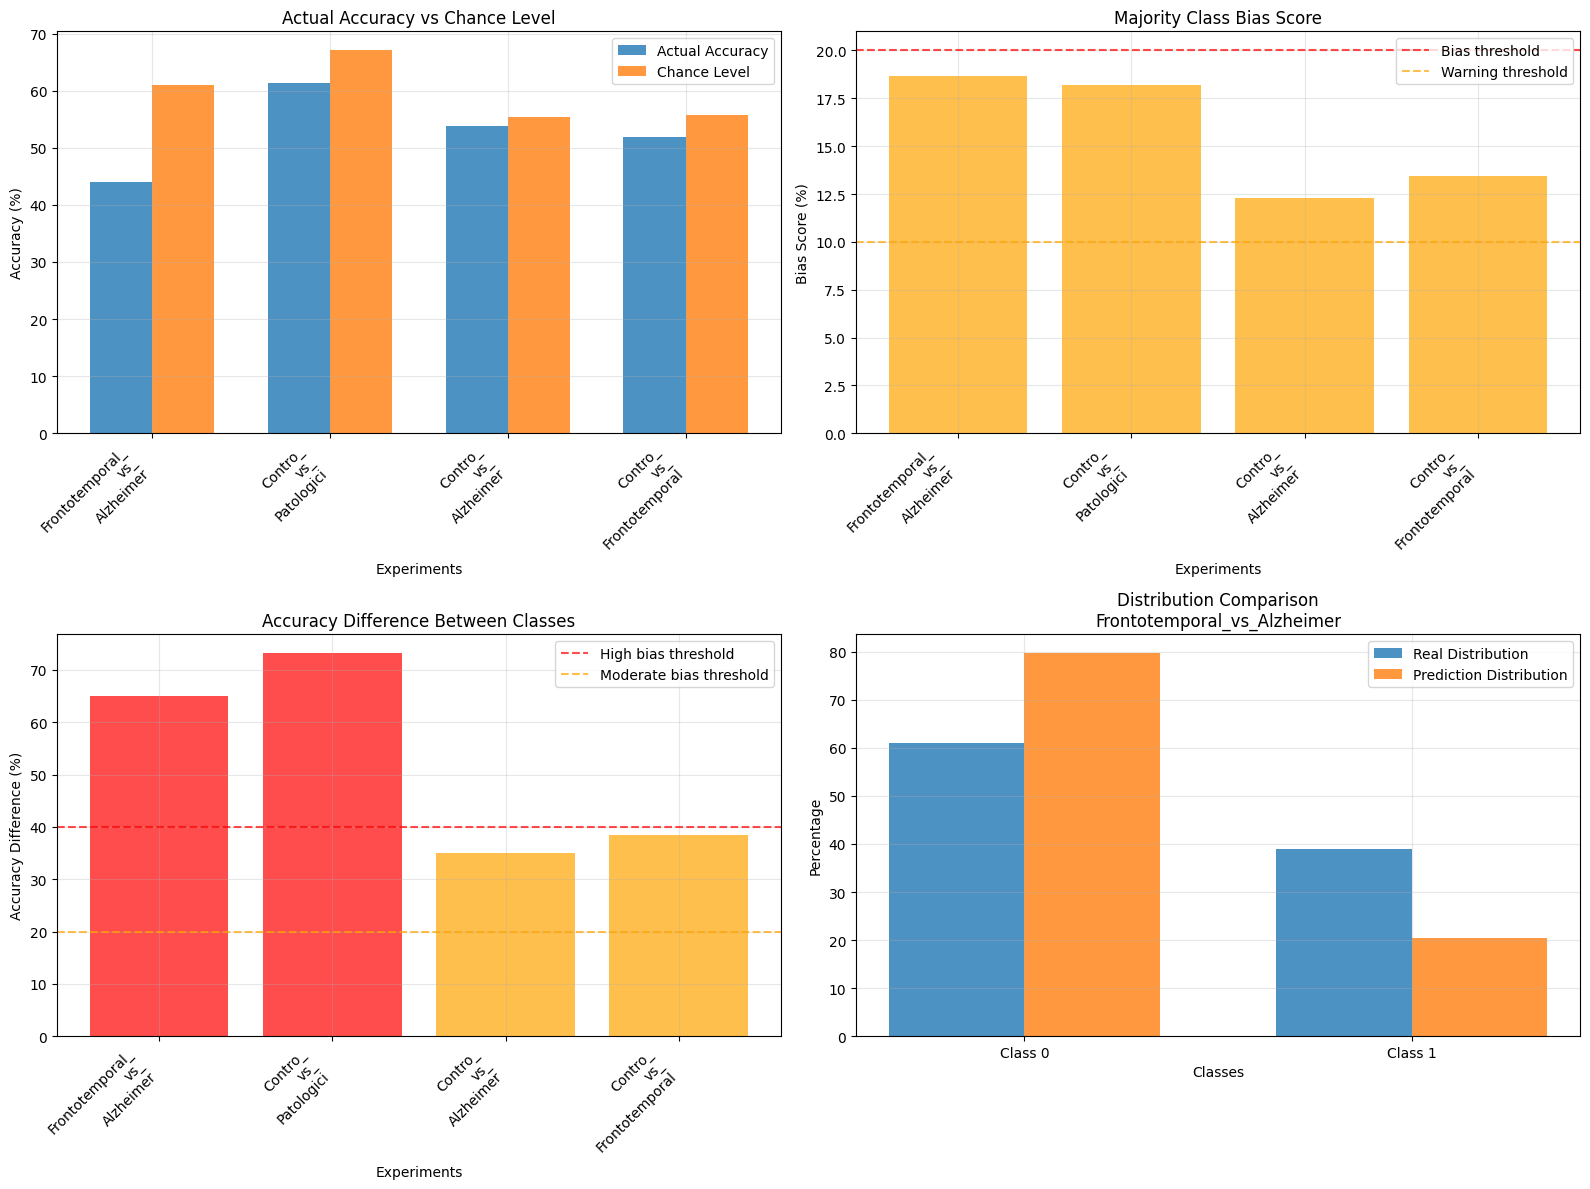


REPORT FINALE ANALISI BIAS

Riepilogo generale:
• Esperimenti totali: 4
• Esperimenti con possibile bias: 2
• Percentuale esperimenti puliti: 50.0%

Dettaglio per esperimento:

- Frontotemporal_vs_Alzheimer: ! BIAS RILEVATO
   Accuracy: 44.1% (Chance level: 61.0%)
   Miglioramento su chance: -16.9%
   Bias score: 18.6%
   Motivi bias: Grande differenza di accuracy tra classi
   Accuracy per classe: {'F': 4.3478260869565215, 'A': 69.44444444444444}
   Validità risultato: Bassa (miglioramento: -16.9%, bias: Medio)

- Contro_vs_Patologici: ! BIAS RILEVATO
   Accuracy: 61.4% (Chance level: 67.0%)
   Miglioramento su chance: -5.7%
   Bias score: 18.2%
   Motivi bias: Grande differenza di accuracy tra classi, Predice quasi sempre la stessa classe
   Accuracy per classe: {'F': 86.95652173913044, 'A': 83.33333333333334, 'C': 13.793103448275861}
   Validità risultato: Bassa (miglioramento: -5.7%, bias: Medio)

- Contro_vs_Alzheimer: PULITO
   Accuracy: 53.8% (Chance level: 55.4%)
   Migliorame

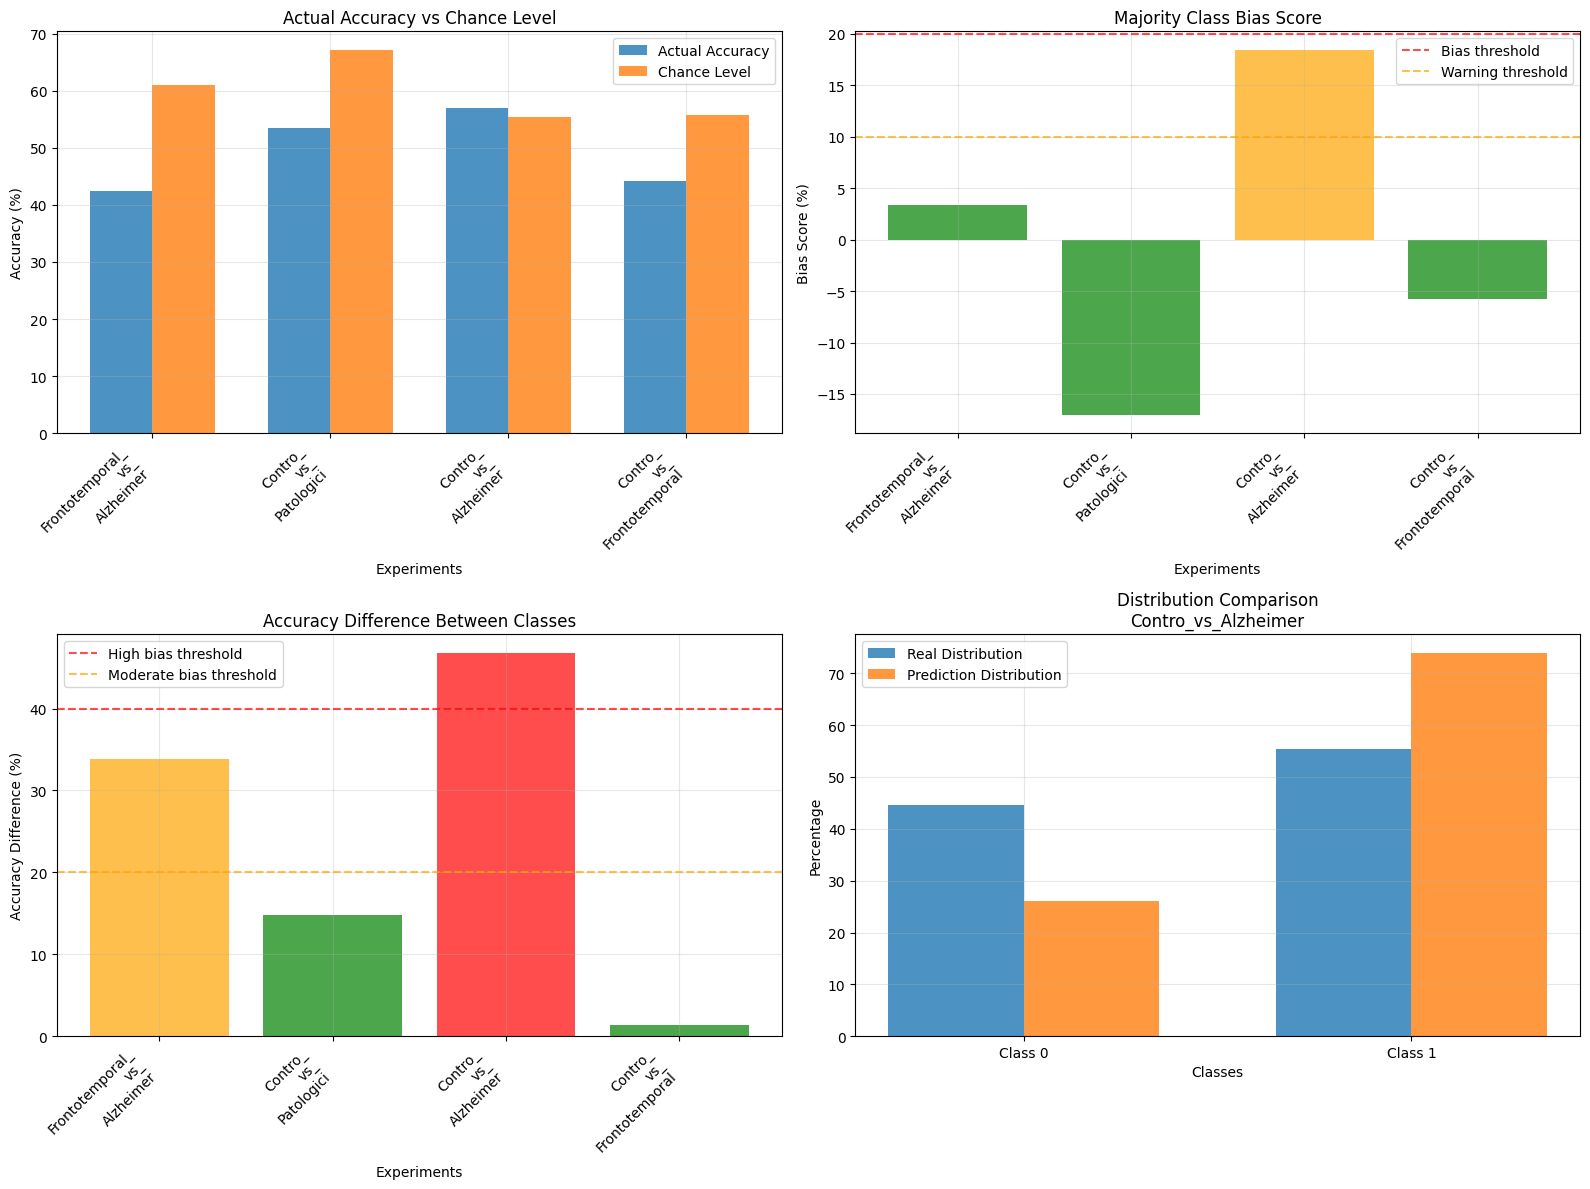


REPORT FINALE ANALISI BIAS

Riepilogo generale:
• Esperimenti totali: 4
• Esperimenti con possibile bias: 1
• Percentuale esperimenti puliti: 75.0%

Dettaglio per esperimento:

- Frontotemporal_vs_Alzheimer: PULITO
   Accuracy: 42.4% (Chance level: 61.0%)
   Miglioramento su chance: -18.6%
   Bias score: 3.4%
   Accuracy per classe: {'F': 21.73913043478261, 'A': 55.55555555555556}
   Validità risultato: Bassa (miglioramento: -18.6%, bias: Basso)

- Contro_vs_Patologici: PULITO
   Accuracy: 53.4% (Chance level: 67.0%)
   Miglioramento su chance: -13.6%
   Bias score: -17.0%
   Accuracy per classe: {'F': 43.47826086956522, 'A': 58.333333333333336, 'C': 55.172413793103445}
   Validità risultato: Bassa (miglioramento: -13.6%, bias: Basso)

- Contro_vs_Alzheimer: ! BIAS RILEVATO
   Accuracy: 56.9% (Chance level: 55.4%)
   Miglioramento su chance: 1.5%
   Bias score: 18.5%
   Motivi bias: Grande differenza di accuracy tra classi
   Accuracy per classe: {'A': 77.77777777777779, 'C': 31.03448

In [13]:

# Configura i percorsi (sostituisci con i tuoi percorsi effettivi)
base_dirs = {
    'EEGNetv4': 'experiment_loso/EEGNetv4/loso_results',
    'Deep4Net': 'experiment_loso/Deep4Net/loso_results'
}
    
    
    # true_labels = {...}  
    
    # Esegui l'analisi completa
bias_results = comprehensive_bias_analysis(base_dirs, true_labels)
    
   